In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.transforms
import seaborn as sns
import math
from math import sqrt, factorial
import re
from itertools import groupby
import scipy
import random
from decimal import Decimal
from operator import itemgetter
import scipy.stats as ss
from CustomFunctions import linear_cycle_utils, utils, DetailedBalance
import multiprocessing
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm 
from statsmodels.formula.api import ols 

#some functions that help find angles between planes

#https://keisan.casio.com/exec/system/1223596129
def plane_eq(points):
    p0 = points[0,:]
    p1 = points[1,:]
    p2 = points[2,:]
    v1 = [p1[0]-p0[0], p1[1]-p0[1], p1[2]-p0[2]]
    v2 = [p2[0]-p0[0], p2[1]-p0[1], p2[2]-p0[2]]
    abc = np.cross(v1, v2)
    d = np.array([abc[0]*p0[0], abc[1]*p0[1], abc[2]*p0[2]])
    return abc, d
# Function to find Angle
def distance(a1, b1, c1, a2, b2, c2):
     
    d = ( a1 * a2 + b1 * b2 + c1 * c2 )
    e1 = math.sqrt( a1 * a1 + b1 * b1 + c1 * c1)
    e2 = math.sqrt( a2 * a2 + b2 * b2 + c2 * c2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A

def angle(a1, b1, a2, b2):
     
    d = ( a1 * a2 + b1 * b2)
    e1 = math.sqrt( a1 * a1 + b1 * b1)
    e2 = math.sqrt( a2 * a2 + b2 * b2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A
def closest(lst, K):  
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]

In [42]:
#get directories and open separated datasets

treatments = ['DMSO','CK666']
time_interval = 10 #sec/frame
whichpcs = [1,7]


basedir = 'E:/Aaron/Combined_37C_Confocal_PCA/'
datadir = basedir + 'Data_and_Figs/'
savedir = basedir + 'CK666/'
if not os.path.exists(savedir):
    os.makedirs(savedir)

FullFrame = pd.read_csv(datadir + 'All_Data_with_CGPS_bins.csv', index_col=0)


nbins = np.max(FullFrame[[x for x in FullFrame.columns.to_list() if 'bin' in x]].to_numpy())

#open the centers of the binned PCs
centers = pd.read_csv(datadir+'PC_bin_centers.csv', index_col=0)


#limit data to the CK666 experiments
TotalFrame = FullFrame[FullFrame.Experiment == 'Drug']
dates = [20240610,20240617,20240620,20241205,20241209]
TotalFrame = TotalFrame[TotalFrame.Date.isin(dates)]
TotalFrame['Treatment'] = pd.Categorical(TotalFrame.Treatment.to_list(), categories=treatments, ordered=True)

In [43]:
################# get "n" of the dataset ###########
inn = len(TotalFrame[TotalFrame.Treatment =='DMSO'])
cn = len(TotalFrame[TotalFrame.Treatment =='DMSO'].CellID.unique())
print(f'There are {inn} images of {cn} unique DMSO cells')
inn = len(TotalFrame[TotalFrame.Treatment =='CK666'])
cn = len(TotalFrame[TotalFrame.Treatment =='CK666'].CellID.unique())
print(f'There are {inn} images of {cn} unique CK666 cells')

There are 25700 images of 294 unique DMSO cells
There are 22369 images of 240 unique CK666 cells


In [44]:
############### linearize PC cycle #############

origin = [7, 7]
whichpcs = [1,7]
binrange = 40
direction = 'clockwise'
zerostart = 'left'

angframe = linear_cycle_utils.linearize_cycle_continuous(
            TotalFrame, 
            centers,
            origin, 
            whichpcs,
            zerostart,
            direction,)

angframe =  linear_cycle_utils.bin_angular_coord(
        angframe,
        whichpcs,
        binrange,
        )

#add protrusion speed
prsplist = []
for i, cells in angframe.groupby('CellID'):
    cells, runs = utils.get_consecutive_timepoints(cells, 'time', time_interval)
    for r in runs:
        tempcell = cells.iloc[r]
        tempcell['protrusion_speed'] = tempcell.LengthAlongTrajectoryFront.diff()
        tempcell['retraction_speed'] = tempcell.LengthAlongTrajectoryRear.diff()
        prsplist.append(tempcell)
angframe = pd.concat(prsplist).reset_index(drop=True)

# #### get a movie of the average SH coeffs around the cycle
# coeff_df = pd.read_csv(datadir + 'Shape_Metrics_with_Digitized_PCs.csv', index_col=0)
# coeffframe = angframe.merge(coeff_df[[x for x in coeff_df.columns.to_list() if 'shco' in x]+['cell']],
#                               left_on = 'cell', right_on = 'cell')
# for t, treat in coeffframe.groupby('Treatment'):
#     linear_cycle_utils.animate_linear_cycle_shcoeffs(
#                             coeffframe,
#                             savedir,
#                             t,
#                             whichpcs,
#                             binrange,
#                             lmax = 10,
#                             smooth = False
#                             )


C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [72]:
##### add aer and cf info to the linearized frame if you want it
if os.path.exists(savedir+f'PC{whichpcs[0]}-PC{whichpcs[1]}_transitions_separated.csv'):
    raw_trans = pd.read_csv(savedir+f'PC{whichpcs[0]}-PC{whichpcs[1]}_transitions_separated.csv', index_col = 0)
    ############# measure aer and cycling frequencies ###########
    #add specific scaling
    xyscaling = [centers[f'PC{whichpcs[0]}'].diff().mean(),centers[f'PC{whichpcs[1]}'].diff().mean()]
    #set the origin to the actual center
    center = [round(nbins/2)]*2
    results = []
    if __name__ == '__main__':
        pool = multiprocessing.Pool(processes=60)
        for i, cells in raw_trans.groupby('CellID'):
            cells, runs = utils.get_consecutive_timepoints(cells, 'frame',1)
            for r in runs:
                cell = cells.iloc[r].reset_index(drop=True)
                result = pool.apply_async(DetailedBalance.get_area_enclosing_rate, args = (
                    cell,
                    nbins,
                    xyscaling,
                    center,
                    ))
                results.append(result)
        pool.close()
        pool.join()
    results = [r.get() for r in results]
    allaers = pd.concat(results).reset_index(drop=True)
allaers['cell'] = [c+f'_frame_{int(f)}' for c, f in allaers[['CellID','frame']].values]
#merge aer and cf info
angframe = angframe.merge(allaers[['aer','angular_velocity','cell']],left_on='cell',right_on='cell')

In [26]:
###################### GET DIRECTIONAL AUTOCORRELATION DECAY #################
treatdas = []
for t, treat in TotalFrame.groupby('Treatment'):
    celldas = []
    for c, cell in treat.groupby('CellID'):
        cell = cell.sort_values('frame').reset_index(drop=True)
        diff = cell.frame.diff()
        difflist = [0]
        difflist.extend(diff[diff>1].index.to_list())
        runs = []
        for x in range(len(difflist)-1):
            runs.append(list(range(difflist[x], difflist[x+1])))
        for r in runs:
            r = np.array(r, dtype=int)
            #skip runs less than 3 frames long
            if len(r)<2:
                pass
            elif len(r)>20:
                r = [r[j:j + 20] for j in range(0, len(r), 20)]
                for rr in r:
                    da = []
                    cellr = cell.iloc[rr]
                    traj = cellr[['Trajectory_X','Trajectory_Y','Trajectory_Z']].to_numpy()
                    unitvecs = traj/np.linalg.norm(traj, axis = 1)[:, np.newaxis]
                    for l in range(1,len(traj)):
                        da.append(sum(unitvecs[0] * unitvecs[l]))
                    celldas.append([da,list(range(len(da)))])
            else:
                da = []
                cellr = cell.iloc[r]
                traj = cellr[['Trajectory_X','Trajectory_Y','Trajectory_Z']].to_numpy()
                unitvecs = traj/np.linalg.norm(traj, axis = 1)[:, np.newaxis]
                for l in range(1,len(traj)):
                    da.append(sum(unitvecs[0] * unitvecs[l]))
                celldas.append([da,list(range(len(da)))])
    treatdas.append(celldas)

In [27]:
dalist = []
for i, t in enumerate(treatdas):
    tlist = []
    for c in t:
        tlist.append(pd.DataFrame(np.array(c).T, columns = ['directional_autocorrelation','delay']))
    tframe = pd.concat(tlist)
    tframe['Treatment'] = treatments[i]
    dalist.append(tframe)
daframe = pd.concat(dalist).reset_index(drop=True)

<AxesSubplot:xlabel='delay', ylabel='directional_autocorrelation'>

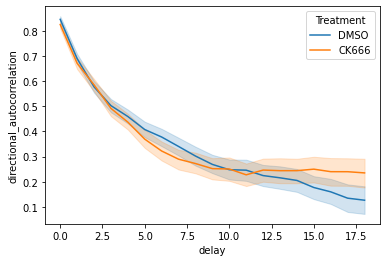

In [29]:
sns.lineplot(data = daframe, x = 'delay', y = 'directional_autocorrelation', hue = 'Treatment')

In [73]:
############### get list of metrics that are significant ttest of CELL AVERAGES ############
ModeFrame = angframe.groupby(['Treatment','CellID']).mean().reset_index(level='Treatment')

siglist = []
new_remove = []
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Axis' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'bin' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'shcoeff' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'frame' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'angle' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'avg' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'raw' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'intensity' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Velocity' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Travel' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if '_X' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if '_Y' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if '_Z' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if '_Coord' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Experiment' in x])
new_remove.extend(['x','y','z','OriginaltoReconError', 'RecontoOriginalError', 'Width_Rotation_Angle',
                   'Date','activity','time','Cell_Volume_Front','Cell_Volume_Right','Cell_Volume_Top',
                   'Cell_UpDownAngle','Cell_LeftRightAngle','Volume_Right_Ratio','Volume_Top_Ratio',
                   'WidthAlongTrajectoryLeft','WidthAlongTrajectoryRight'])

ModeFrame.drop(columns=new_remove).columns.to_list()

['Treatment',
 'Cell_Volume',
 'Volume_Front_Ratio',
 'Cell_SurfaceArea',
 'Cell_Sphericity',
 'Cell_Aspect_Ratio',
 'Cell_TotalAngle',
 'LengthAlongTrajectory',
 'LengthAlongTrajectoryFront',
 'LengthAlongTrajectoryRear',
 'WidthAlongTrajectory',
 'persistence',
 'speed',
 'directional_autocorrelation',
 'Turn_Angle',
 'PC1',
 'PC2',
 'PC3',
 'PC4',
 'PC5',
 'PC6',
 'PC7',
 'PC8',
 'PC9',
 'PC10',
 'PC1_PC7_Continuous_Angular_Bins',
 'protrusion_speed',
 'retraction_speed',
 'aer',
 'angular_velocity']

In [65]:
############### get list of metrics that are significant ttest of CELL AVERAGES ############
ModeFrame = angframe.groupby(['Treatment','CellID']).mean().reset_index(level='Treatment')

siglist = []
new_remove = []
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Axis' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'bin' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'shcoeff' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'frame' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'angle' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'avg' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'raw' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'intensity' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Velocity' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Travel' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if '_X' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if '_Y' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if '_Z' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if '_Coord' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Experiment' in x])
new_remove.extend(['x','y','z','OriginaltoReconError', 'RecontoOriginalError', 'Width_Rotation_Angle',
                   'Date','activity','time','Cell_Volume_Front','Cell_Volume_Right','Cell_Volume_Top',
                   'Cell_UpDownAngle','Cell_LeftRightAngle','Volume_Right_Ratio','Volume_Top_Ratio',
                   'WidthAlongTrajectoryLeft','WidthAlongTrajectoryRight'])

plist = []
for c in ModeFrame.drop(columns=new_remove).columns.to_list():
    if c != 'Treatment':
        samples = [g[1].dropna() for g in ModeFrame.groupby('Treatment')[c]]
        test_stat, p_val = ss.ttest_ind(samples[0], samples[1])   
        plist.append([c, p_val])
        if p_val < 0.05:
            siglist.append(c)
            print(f'Name: {c}, t-statistic: {test_stat}, p value: {p_val}')

#correct for multiple comparisons
from statsmodels.stats.multitest import multipletests
reject, pvcorr = multipletests(np.array(plist)[:,1].astype('float'), method='bonferroni')[:2]
corsiglist = list(np.array(plist)[reject,0])

Name: Volume_Front_Ratio, t-statistic: 2.5845578011767163, p value: 0.0100812618191393
Name: speed, t-statistic: 2.0782182114139784, p value: 0.0382874279579635
Name: PC2, t-statistic: 2.1710312178228275, p value: 0.030478969106689575
Name: PC7, t-statistic: -2.0091313178929124, p value: 0.04515207974167583
Name: PC9, t-statistic: 2.024387064215722, p value: 0.04355235037475246


In [53]:
corsiglist

[]

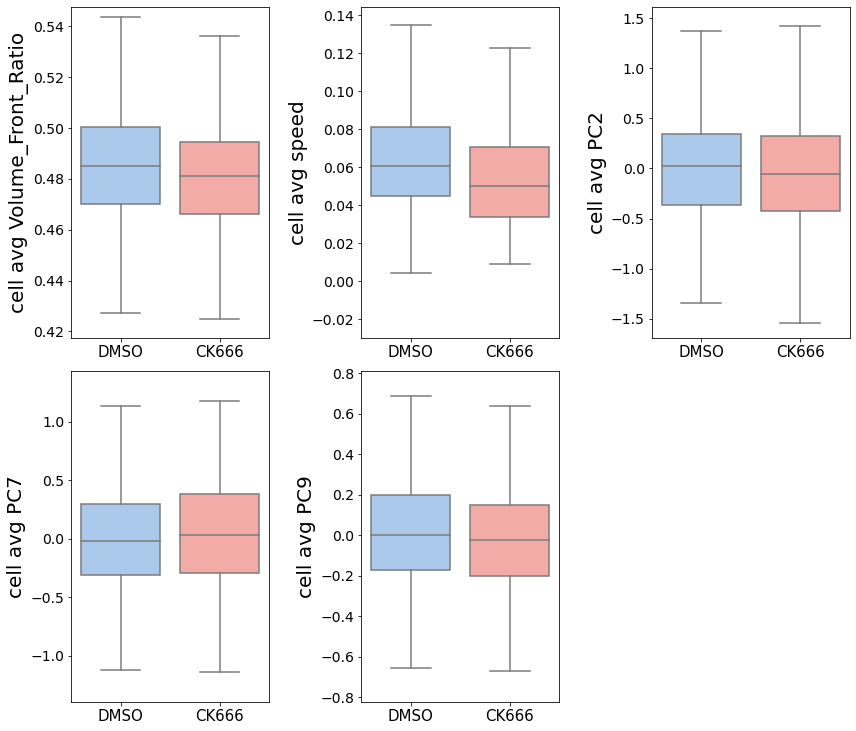

In [46]:
############### CELL AVERAGES OF SIGNIFICANT METRICS #################################
colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]


sp = math.ceil(math.sqrt(len(siglist)))
fig, axes = plt.subplots(sp, sp, figsize=(sp*4,sp*5))#, sharex=True)
axli = axes.flatten()
sigframe = TotalFrame.groupby(['Treatment','CellID'])
for i, sig in enumerate(siglist):
#     vp = sns.violinplot(data=tempframe, x='Treatment', y=sig, hue = 'Temperature', palette = colorlist, inner = None, ax=axli[i], )
    mean = sigframe[sig].mean()
    st = sigframe[sig].std()
    tempframe = pd.DataFrame({'avg':mean,'st':st}).reset_index(level='Treatment')
    
#     # Add colorbar
#     norm = plt.Normalize(tempframe['st'].min(), tempframe['st'].max())
#     sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
#     sm.set_array([])
#     cbar = fig.colorbar(sm, ax=axli[i])
    
    #plots
#     sns.stripplot(data=tempframe, x='Treatment', y='avg', hue = 'st', palette = 'viridis', ax=axli[i])
    sns.boxplot(data=tempframe, x='Treatment', y='avg', palette = colorlist,# width = 0.15, 
            fliersize=0, boxprops={'zorder': 2}, ax=axli[i])
    Q1 = tempframe['avg'].quantile(0.25)
    Q3 = tempframe['avg'].quantile(0.75)  
    IQR = Q3 - Q1
    axli[i].set_ylim(Q1 - 1.75*IQR, Q3 + 1.75*IQR)
    axli[i].set_ylabel('cell avg '+sig, fontsize=20)
    axli[i].set_xlabel('', fontsize=20)
    axli[i].tick_params('y', labelsize=14)
    #modify the labels to put bleb in two lines
    axli[i].set_xticklabels(axli[i].get_xticklabels(), fontsize = 15)
    #remove legends
    axli[i].legend_ = None

for a in range(i+1, len(axli)):
    axli[a].remove()

    
plt.tight_layout()
# plt.savefig(savedir + 'Drug comparison average significant metric boxes.png', bbox_inches='tight')



In [66]:
############### get list of metrics that are significant ttest of CELL STDEVS ############
ModeFrame = angframe.groupby(['Treatment','CellID']).std().reset_index(level='Treatment')

siglist = []
new_remove = []
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Axis' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'bin' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'shcoeff' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'frame' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'angle' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'avg' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'raw' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'intensity' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Velocity' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Travel' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if '_X' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if '_Y' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if '_Z' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if '_Coord' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Experiment' in x])
new_remove.extend(['x','y','z','OriginaltoReconError', 'RecontoOriginalError', 'Width_Rotation_Angle',
                   'Date','activity','time','Cell_Volume_Front','Cell_Volume_Right','Cell_Volume_Top',
                   'Cell_UpDownAngle','Cell_LeftRightAngle','Volume_Right_Ratio','Volume_Top_Ratio',
                   'WidthAlongTrajectoryLeft','WidthAlongTrajectoryRight'])
plist = []
for c in ModeFrame.drop(columns=new_remove).columns.to_list():
    if c != 'Treatment':
        samples = [g[1].dropna() for g in ModeFrame.groupby('Treatment')[c]]
        test_stat, p_val = ss.ttest_ind(samples[0], samples[1])   
        plist.append([c, p_val])
        if p_val < 0.05:
            siglist.append(c)
            print(f'Name: {c}, t-statistic: {test_stat}, p value: {p_val}')

#correct for multiple comparisons
from statsmodels.stats.multitest import multipletests
reject, pvcorr = multipletests(np.array(plist)[:,1].astype('float'), method='bonferroni')[:2]
corsiglist = list(np.array(plist)[reject,0])

Name: Cell_SurfaceArea, t-statistic: -3.438338578474449, p value: 0.0006436085079065204
Name: Cell_Sphericity, t-statistic: -2.9936696707773804, p value: 0.002918881634193526
Name: LengthAlongTrajectory, t-statistic: -2.2827794453988135, p value: 0.02294117755114413
Name: LengthAlongTrajectoryFront, t-statistic: -2.8473651623925766, p value: 0.00462407358829621
Name: speed, t-statistic: 2.80702274657833, p value: 0.005235265248981885
Name: PC3, t-statistic: -2.5306204616949524, p value: 0.011749474460927934


In [67]:
corsiglist

['Cell_SurfaceArea']

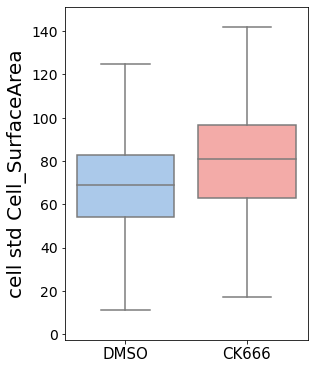

In [59]:
############### CELL AVERAGES OF SIGNIFICANT METRICS #################################
colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]


sp = math.ceil(math.sqrt(len(siglist)))
fig, axes = plt.subplots(sp, sp, figsize=(sp*4,sp*5))#, sharex=True)
axli = axes.flatten()
sigframe = TotalFrame.groupby(['Treatment','CellID'])
for i, sig in enumerate(corsiglist):
#     vp = sns.violinplot(data=tempframe, x='Treatment', y=sig, hue = 'Temperature', palette = colorlist, inner = None, ax=axli[i], )
    mean = sigframe[sig].mean()
    st = sigframe[sig].std()
    tempframe = pd.DataFrame({'avg':mean,'st':st}).reset_index(level='Treatment')
    
#     # Add colorbar
#     norm = plt.Normalize(tempframe['st'].min(), tempframe['st'].max())
#     sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
#     sm.set_array([])
#     cbar = fig.colorbar(sm, ax=axli[i])
    
    #plots
#     sns.stripplot(data=tempframe, x='Treatment', y='avg', hue = 'st', palette = 'viridis', ax=axli[i])
    sns.boxplot(data=tempframe, x='Treatment', y='st', palette = colorlist,# width = 0.15, 
            fliersize=0, boxprops={'zorder': 2}, ax=axli[i])
    Q1 = tempframe['st'].quantile(0.25)
    Q3 = tempframe['st'].quantile(0.75)  
    IQR = Q3 - Q1
    axli[i].set_ylim(Q1 - 1.75*IQR, Q3 + 1.75*IQR)
    axli[i].set_ylabel('cell std '+sig, fontsize=20)
    axli[i].set_xlabel('', fontsize=20)
    axli[i].tick_params('y', labelsize=14)
    #modify the labels to put bleb in two lines
    axli[i].set_xticklabels(axli[i].get_xticklabels(), fontsize = 15)
    #remove legends
    axli[i].legend_ = None

for a in range(i+1, len(axli)):
    axli[a].remove()

    
plt.tight_layout()
# plt.savefig(savedir + 'Drug comparison stdev significant metric boxes.png', bbox_inches='tight')



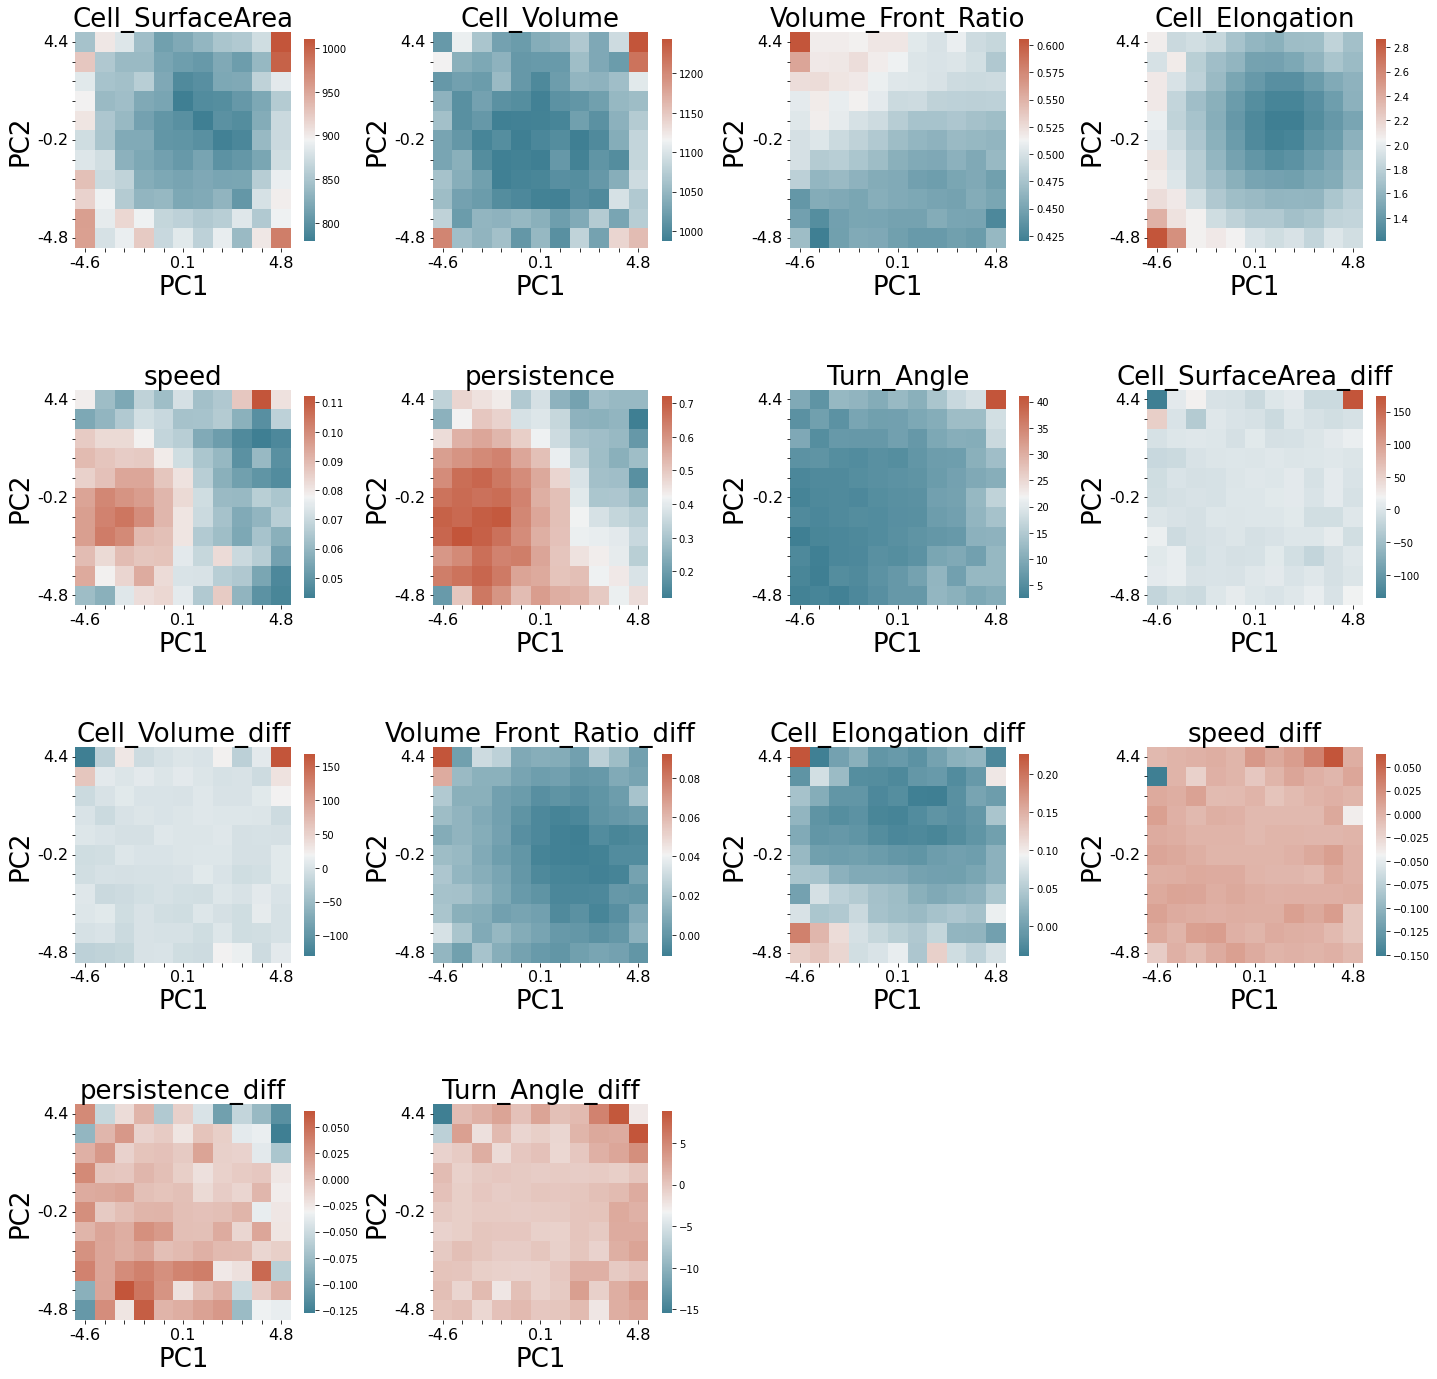

In [6]:
########### PLOT THE DISTRIBUTIONS OF SHAPE METRICS #############
############ IN THE COARSE GRAINED PHASE SPACE ###############

#add some metric differentials
metrics = ['Cell_SurfaceArea','Cell_Volume','Volume_Front_Ratio','Cell_Elongation','speed','persistence','Turn_Angle']
TotalFrame = TotalFrame.sort_values(['CellID','frame'])
diffmets = metrics.copy()
for d in metrics:
    TotalFrame[d+'_diff'] = TotalFrame[d].diff()
    diffmets.append(d+'_diff')

#make subplots
sp = math.ceil(math.sqrt(len(diffmets)))
fig, axes = plt.subplots(sp,sp,figsize=(sp*5,sp*5))

for i, ax in enumerate(axes.flatten()):
    if i<len(diffmets):
        ################ heatmap of the given metric #############
        #make numpy array with heatmap data
        bighm = np.zeros((nbins,nbins))
        for x in range(nbins):
            for y in range(nbins):
                current =  TotalFrame[(TotalFrame['PC1bins'] == x+1) & (TotalFrame['PC2bins'] == y+1)]
                if current.empty:
                    bighm[y,x] = 0
                elif len(current)==1:
                    bighm[y,x] = current[diffmets[i]]
                else:
                    bighm[y,x] = current[diffmets[i]].mean()


        #plot heatmap with seaborn
        #### use the max and the lowest non zero as min
        sns.heatmap(
            bighm,
            vmin=np.min(bighm[np.nonzero(bighm)]),
            vmax=bighm.max(), #center=0,
            cmap=sns.diverging_palette(220, 20, n=200),
            square=True,
            xticklabels = True,
            yticklabels = True,
            ax = ax,
            cbar_kws={'shrink': 0.65}
        )
        ax.set_xticklabels(
            [round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])],
            fontsize = 16
        )
        ax.set_yticklabels(
            [round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])],
            rotation=0,
            fontsize = 16
        )
        #take out all axis labels except the desired ones
        for o, l in enumerate(ax.xaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        for o, l in enumerate(ax.yaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        #set axis titles
        ax.set_xlabel('PC1', fontsize = 26)
        ax.set_ylabel('PC2', fontsize = 26)
        #correct axis orientations
        ax.invert_yaxis()
        #set title
        ax.set_title(diffmets[i], fontsize = 26)
    else:
        ax.remove()

# adjust colorbar tick label size
# cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)
#set axis title
axes.flatten()[0].set_ylabel('PC2', fontsize = 26)

plt.tight_layout()
plt.savefig(savedir + 'PC1_PC2 metric heatmaps.png', bbox_inches='tight')

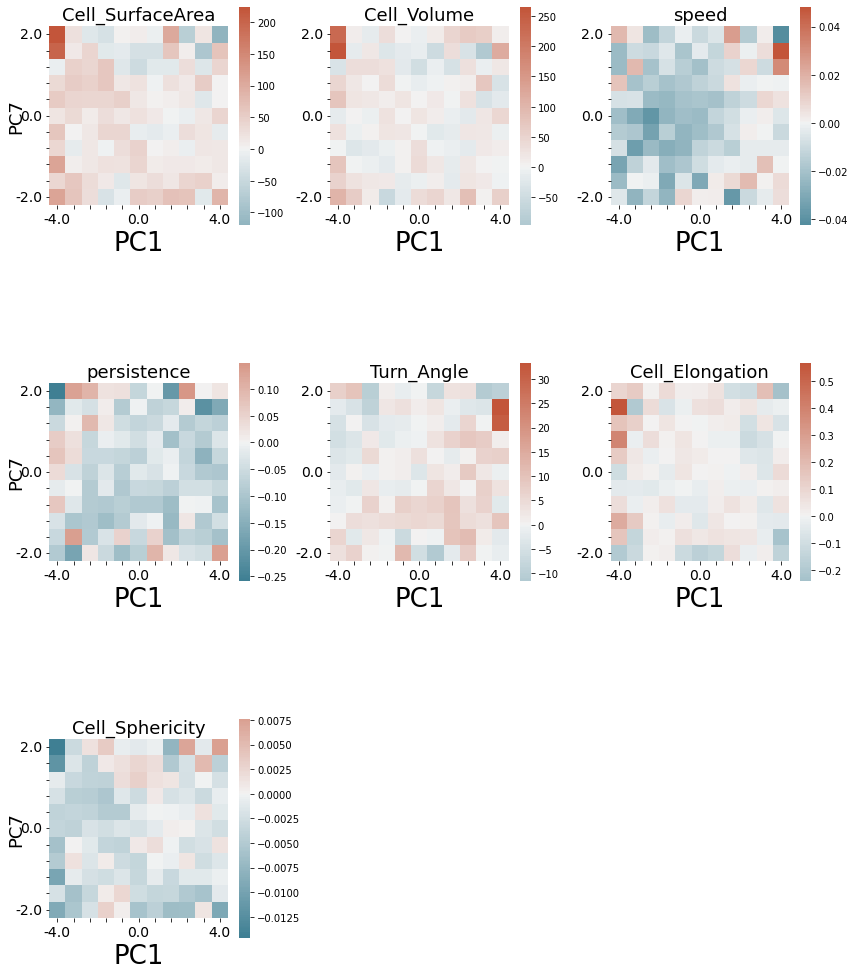

In [7]:
########### PLOT THE DIFFERENCE DISTRIBUTIONS OF SHAPE METRICS #############
############ IN THE COARSE GRAINED PHASE SPACE ###############

metrics = ['Cell_SurfaceArea','Cell_Volume','speed','persistence','Turn_Angle','Cell_Elongation', 'Cell_Sphericity']

sp = math.ceil(math.sqrt(len(metrics)))
fig, axes = plt.subplots(sp, sp, figsize=(sp*4,sp*5))#, sharex=True)
axf = axes.flatten()
for i, met in enumerate(metrics):
    ax = axf[i]
    ################ heatmap of the given metric #############
    #make numpy array with heatmap data
    bighm = np.zeros((len(TotalFrame.Treatment.unique()),nbins,nbins))
    for n in range(bighm.shape[0]):
        mdf = TotalFrame[TotalFrame.Treatment==TotalFrame.Treatment.unique()[n]]
        for x in range(nbins):
            for y in range(nbins):
                current =  mdf[(mdf['PC1bins'] == x+1) & (mdf['PC7bins'] == y+1)].dropna(subset=[met])
                if current.empty:
                    bighm[n,y,x] = 0
                elif len(current)==1:
                    bighm[n,y,x] = current[met]
                else:
                    bighm[n,y,x] = current[met].mean()

    diffhm = bighm[1,:,:]-bighm[0,:,:]
    #plot heatmap with seaborn
    #### use the max and the lowest non zero as min
    sns.heatmap(
        diffhm,
        #vmin=np.min(bighm[np.nonzero(bighm)]),
        #vmax=np.max(bighm),
        center=0,
        cmap=sns.diverging_palette(220, 20, n=200),
        square=True,
        xticklabels = True,
        yticklabels = True,
        ax = ax,
        cbar_kws={'shrink': 0.65}
    )
    ax.set_xticklabels(
            [round(x,1) for x in centers.PC1.to_list()],
            fontsize = 14
        )
    ax.set_yticklabels(
        [round(x,1) for x in centers.PC7.to_list()],
        rotation=0,
        fontsize = 14
    )
    #take out all axis labels except the desired ones
    for o, l in enumerate(ax.xaxis.get_ticklabels()):
        if o%5 != 0:
            l.set_visible(False)
    for o, l in enumerate(ax.yaxis.get_ticklabels()):
        if o%5 != 0:
            l.set_visible(False)
    #set axis titles
    ax.set_xlabel('PC1', fontsize = 26)      
    if (i%sp ==0):
        ax.set_ylabel('PC7', fontsize = 18, labelpad=-10)
#         else:
#             ax.set_ylabel(f'PC2', fontsize = 26, labelpad=-10)
    #correct axis orientations
    ax.invert_yaxis()
    #set title
    ax.set_title(met, fontsize = 18)
for a in range(i+1, len(axf)):
    axf[a].remove()

# adjust colorbar tick label size
# cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)
#set axis title

plt.tight_layout()
plt.savefig(savedir + 'PC1_PC7 difference heatmaps.png', bbox_inches='tight')

In [79]:
############## two way anova to test for interactions of cycle position and metrics
new_remove = []
new_remove.extend([x for x in angframe.columns.to_list() if 'Axis' in x])
new_remove.extend([x for x in angframe.columns.to_list() if 'bin' in x])
new_remove.extend([x for x in angframe.columns.to_list() if 'shcoeff' in x])
new_remove.extend([x for x in angframe.columns.to_list() if 'frame' in x])
new_remove.extend([x for x in angframe.columns.to_list() if 'angle' in x])
new_remove.extend([x for x in angframe.columns.to_list() if 'avg' in x])
new_remove.extend([x for x in angframe.columns.to_list() if 'raw' in x])
new_remove.extend([x for x in angframe.columns.to_list() if 'intensity' in x])
new_remove.extend([x for x in angframe.columns.to_list() if 'Velocity' in x])
new_remove.extend([x for x in angframe.columns.to_list() if 'Travel' in x])
new_remove.extend([x for x in angframe.columns.to_list() if '_X' in x])
new_remove.extend([x for x in angframe.columns.to_list() if '_Y' in x])
new_remove.extend([x for x in angframe.columns.to_list() if '_Z' in x])
new_remove.extend([x for x in angframe.columns.to_list() if '_Coord' in x])
new_remove.extend([x for x in angframe.columns.to_list() if 'Experiment' in x])
new_remove.extend(['x','y','z','OriginaltoReconError', 'RecontoOriginalError', 'Width_Rotation_Angle',
                   'Date','activity','time','Cell_Volume_Front','Cell_Volume_Right','Cell_Volume_Top',
                   'Cell_UpDownAngle','Cell_LeftRightAngle','Volume_Right_Ratio','Volume_Top_Ratio',
                   'WidthAlongTrajectoryLeft','WidthAlongTrajectoryRight','cell','aer','CellID','structure','persistence'])
newframe = angframe.drop(columns =new_remove)
newframe.columns.to_list()

reslist = []
for col in newframe.columns.to_list():
    if col not in ['PC1_PC7_Continuous_Angular_Bins','Treatment']:
        model = ols(f'{col} ~ C(Treatment) + C(PC1_PC7_Continuous_Angular_Bins) + C(Treatment):C(PC1_PC7_Continuous_Angular_Bins)', 
                    data=angframe).fit() 
        result = sm.stats.anova_lm(model, type=2)
#         result = result.reset_index()
        result['Factor'] = [col]*len(result)
        reslist.append(result)

,df,sum_sq,mean_sq,F,PR(>F),Factor
C(Treatment),1.0,5.196681e+06,5.196681e+06,226.580087,5.227780e-51,Cell_Volume
C(PC1_PC7_Continuous_Angular_Bins),17.0,9.043730e+07,5.319841e+06,231.949974,0.000000e+00,Cell_Volume
C(Treatment):C(PC1_PC7_Continuous_Angular_Bins),17.0,1.195519e+06,7.032462e+04,3.066218,1.988532e-05,Cell_Volume
Residual,28375.0,6.507890e+08,2.293529e+04,NaN,NaN,Cell_Volume
C(Treatment),1.0,1.514487e-01,1.514487e-01,78.623466,7.945920e-19,Volume_Front_Ratio
...,...,...,...,...,...,...
Residual,26566.0,1.921603e+04,7.233316e-01,NaN,NaN,retraction_speed
C(Treatment),1.0,1.122811e+02,1.122811e+02,11.168543,8.330336e-04,angular_velocity
C(PC1_PC7_Continuous_Angular_Bins),17.0,9.711436e+02,5.712609e+01,5.682302,4.009656e-13,angular_velocity
C(Treatment):C(PC1_PC7_Continuous_Angular_Bins),17.0,2.656974e+02,1.562926e+01,1.554634,6.708331e-02,angular_velocity


In [85]:
######### pvalue correction on the two way anovas
pvdf = pd.concat(reslist)
pvdf = pvdf[pvdf.index=='C(Treatment):C(PC1_PC7_Continuous_Angular_Bins)'].reset_index(drop=True)
reject, pvcorr = multipletests(pvdf['PR(>F)'],method='bonferroni')[:2]
siglist = pvdf.iloc[reject]

,df,sum_sq,mean_sq,F,PR(>F),Factor
0,17.0,1.195519e+06,70324.619895,3.066218,1.988532e-05,Cell_Volume
1,17.0,1.075512e-01,0.006327,3.284375,5.105185e-06,Volume_Front_Ratio
2,17.0,9.170184e+05,53942.258839,3.144742,1.223411e-05,Cell_SurfaceArea
4,17.0,8.262892e+00,0.486052,6.157240,1.290637e-14,Cell_Aspect_Ratio
6,17.0,1.728797e+03,101.693936,8.517560,2.946492e-22,LengthAlongTrajectory
7,17.0,3.530060e+02,20.765056,7.663798,1.857046e-19,LengthAlongTrajectoryFront
8,17.0,5.723494e+02,33.667613,7.388551,1.458038e-18,LengthAlongTrajectoryRear
10,17.0,1.731579e-01,0.010186,6.314436,4.103720e-15,speed
13,17.0,5.862148e+01,3.448322,4.092158,2.629222e-08,PC1
16,17.0,7.718517e+01,4.540304,3.000565,2.974827e-05,PC4


C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == "":
C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\numpy\lib\nanfunctions.py:1376: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
C:\ProgramData\anac

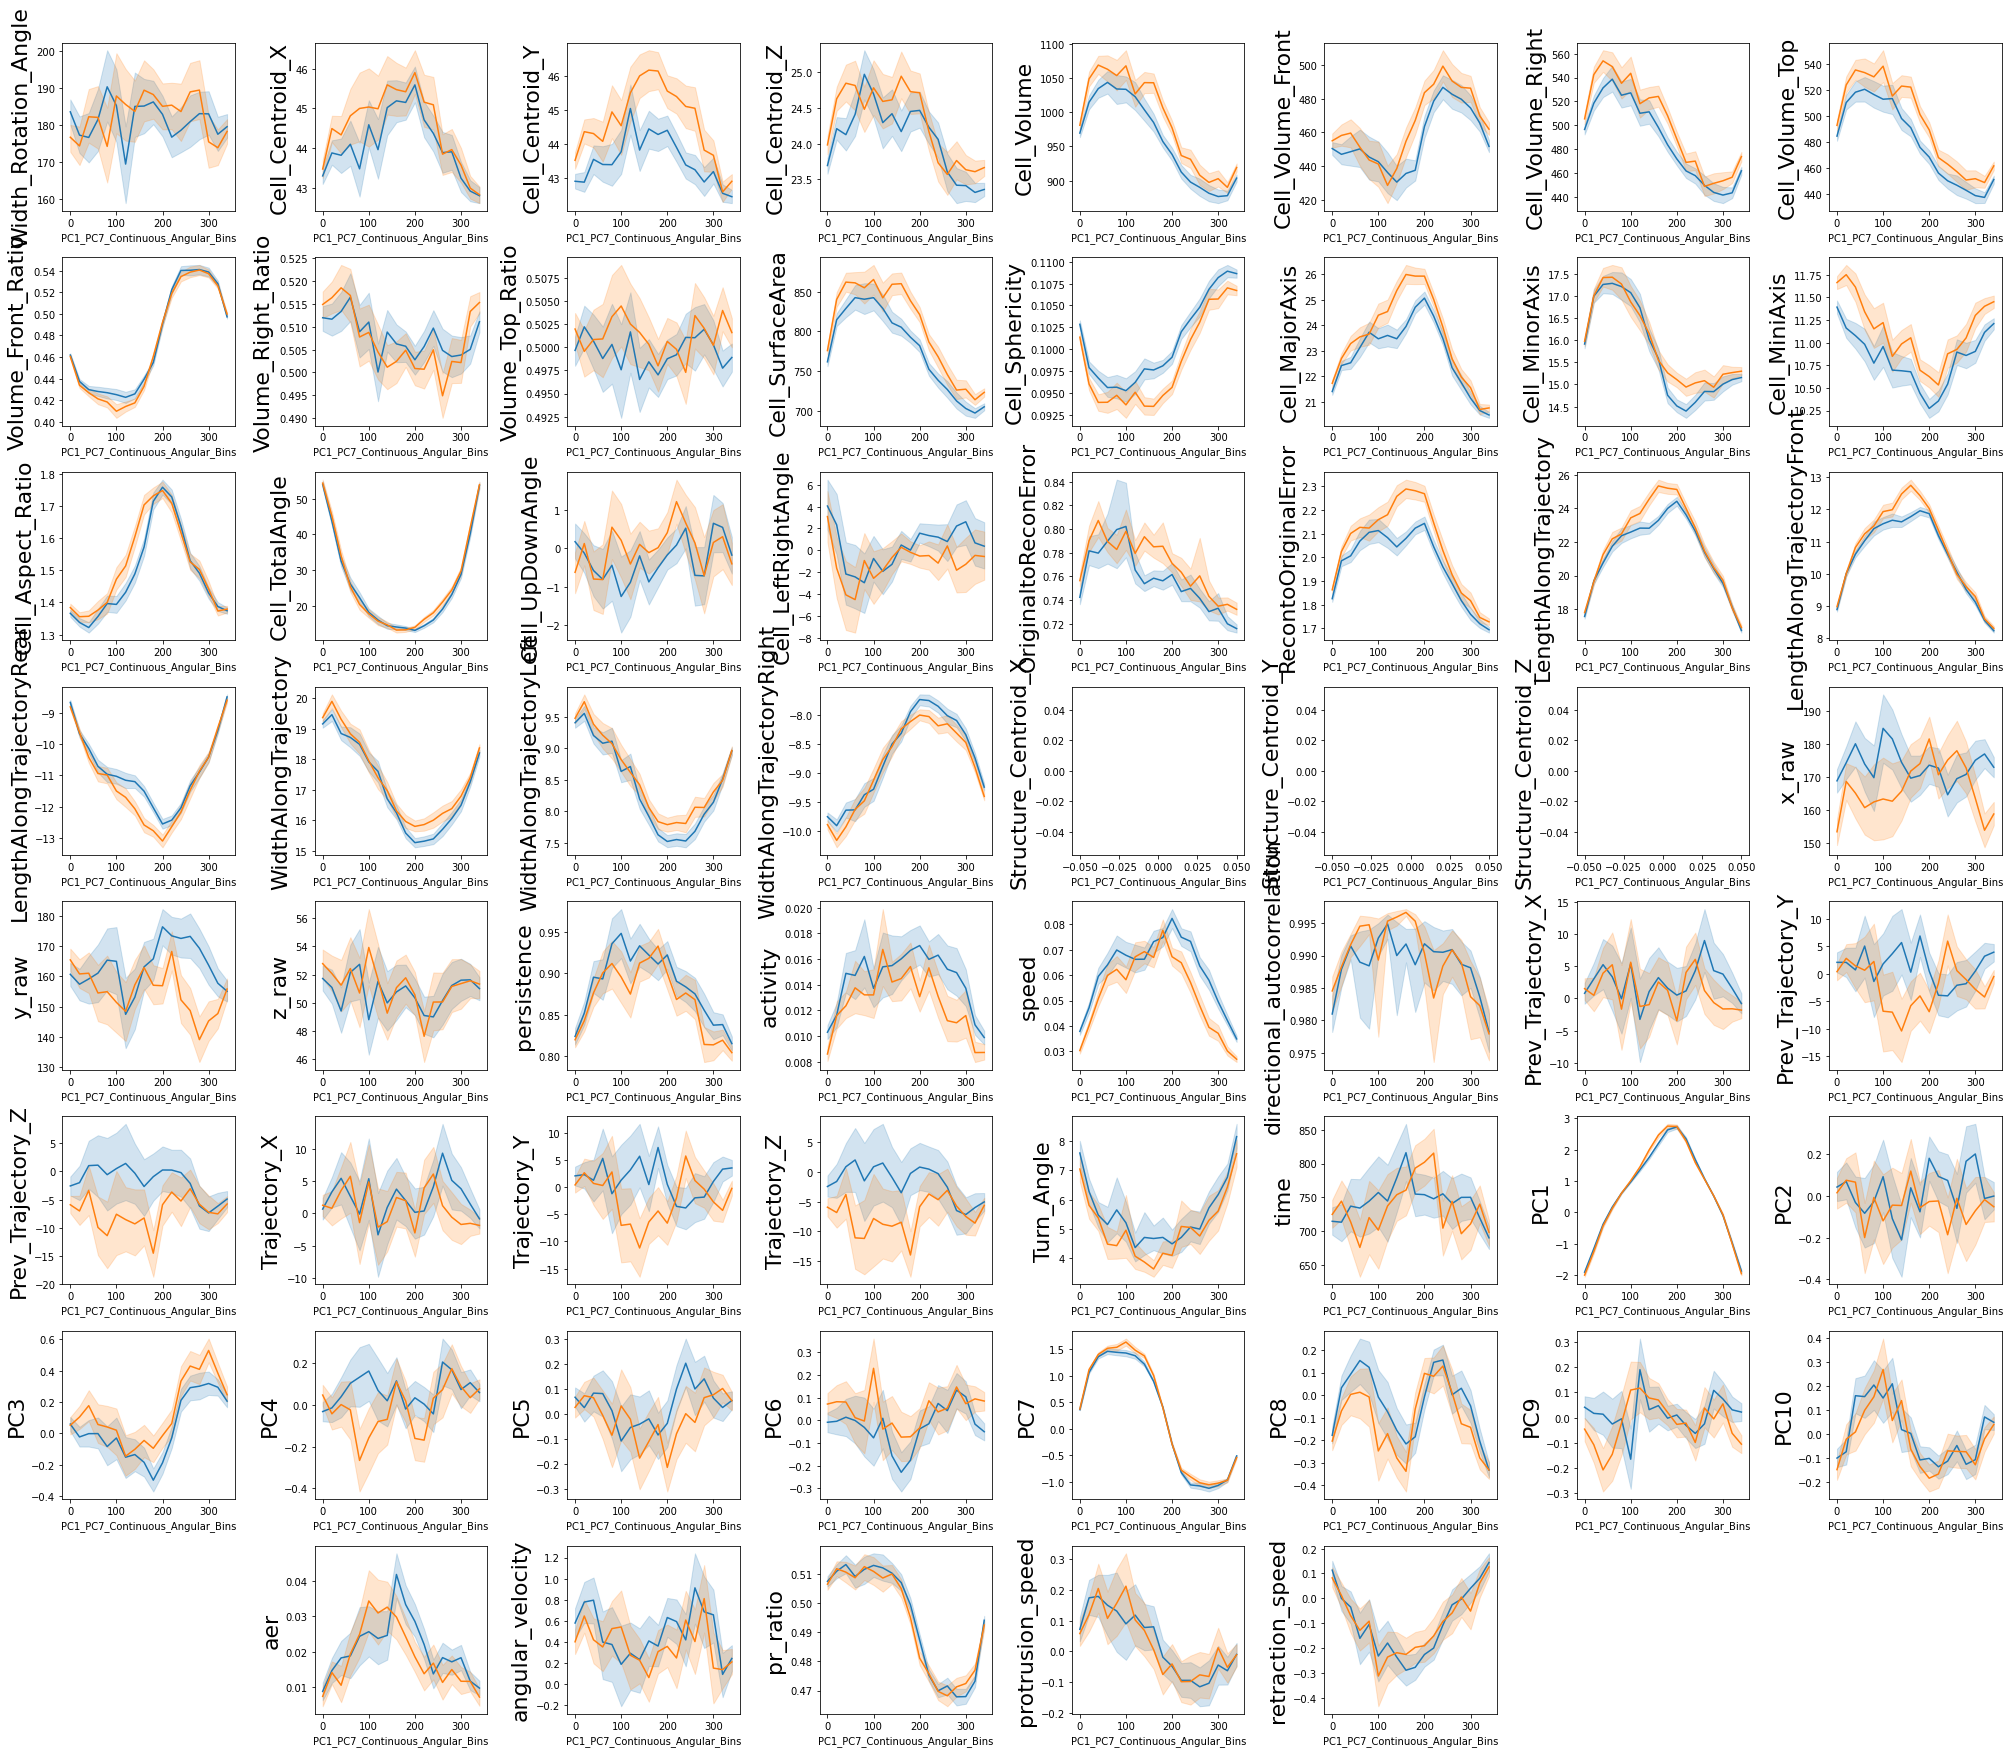

In [17]:
################# LOOK STATS AROUND 1D CYCLE ######################


removeex = []
removeex.extend([x for x in angframe.columns if 'Euler' in x])
removeex.extend([x for x in angframe.columns if 'avg' in x])
removeex.extend([x for x in angframe.columns if 'intensity' in x])
removeex.extend([x for x in angframe.columns if 'Velocity' in x])
removeex.extend([x for x in angframe.columns if 'Coord' in x])
removeex.extend([x for x in angframe.columns if 'Vec' in x])
removeex.extend([x for x in angframe.columns if 'bins' in x])
removeex.extend(['cell','CellID','x','y','z','structure','frame','Treatment','Experiment','Date'])
newframe = angframe.drop(columns =removeex)


CoRo = math.ceil(math.sqrt(len(newframe.columns)))
row = 0
fig, axes = plt.subplots(CoRo, CoRo, figsize=(3.5*CoRo,3*CoRo))#, sharex=True)

for i, ax in enumerate(axes.flatten()):
    if i<len(newframe.columns):
        if newframe.iloc[:,i].name == f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Bins':
            ax.remove()
            continue
        sns.lineplot(data = angframe, x=f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Bins', 
                     y = newframe.iloc[:,i].name, hue = 'Treatment', ax = ax)
        ax.set_ylabel(newframe.iloc[:,i].name)#, fontsize = 1.75*CoRo)
        ax.legend_ = None
        ax.set_ylabel(ax.get_ylabel(), fontsize = 22)
    else:
        ax.remove()


plt.tight_layout()
plt.savefig(savedir + f'PC{whichpcs[0]}_PC{whichpcs[1]} Shape Metrics 1D Continuous PCs.png', bbox_inches='tight')

In [ ]:
############### linear statistics #####################
####### JUST THE ONES SIGNIFICANT BY two-way ANOVA with Cycle angle and Treatment


In [45]:
############## bootstrap around the linear cycle for metrics ###################

if os.path.exists(savedir + f'PC{whichpcs[0]}_PC{whichpcs[1]}_linear_CGPS_bootstrapped_metrics_binrange{binrange}.csv'):
    allavgsframe = pd.read_csv(savedir + f'PC{whichpcs[0]}_PC{whichpcs[1]}_linear_CGPS_bootstrapped_metrics_binrange{binrange}.csv', index_col=0)
    print('Opened bootstrap file')
else:    
    
    samplesize = 1000
    bsiters = 1000
    allavgs = []
    ### generate the dataframe with all of the sampled data
    includelist = ['cell','CellID','structure','Treatment','Experiment','Cell_Volume','Volume_Front_Ratio','Cell_SurfaceArea','Cell_Sphericity','Cell_Aspect_Ratio',
       'LengthAlongTrajectory','LengthAlongTrajectoryFront','LengthAlongTrajectoryRear','WidthAlongTrajectory',
       'speed','directional_autocorrelation','Turn_Angle','PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10',
       'PC1_PC7_Continuous_Angular_Bins','protrusion_speed','retraction_speed']
    includeframe = angframe[includelist]
    for t in includeframe.Treatment.unique():
        treattemp = includeframe[includeframe.Treatment == t].copy()
        for b in range(bsiters):
            #sample images by the sample size
            sampleddf = treattemp[treattemp.cell.isin(random.sample(treattemp.cell.to_list(), samplesize))].copy()
            #add boostrap iteration
            sampleddf['bsiter'] = [b]*samplesize
            for a, ab in sampleddf.groupby(f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Bins'):
                ab['bsiter'] = [i]* len(ab)
                abavg = ab.mean()
                #add correct non-numeric identifiers
                for index, value in zip(['cell','CellID','structure','Treatment','Experiment'],
                                       ab[['cell','CellID','structure','Treatment','Experiment']].iloc[0].values):
                    abavg[index] = value
                allavgs.append(abavg)
            
            
    allavgsframe = pd.DataFrame(allavgs)
    allavgsframe.to_csv(savedir + f'PC{whichpcs[0]}_PC{whichpcs[1]}_linear_CGPS_bootstrapped_metrics_binrange{binrange}.csv')

C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


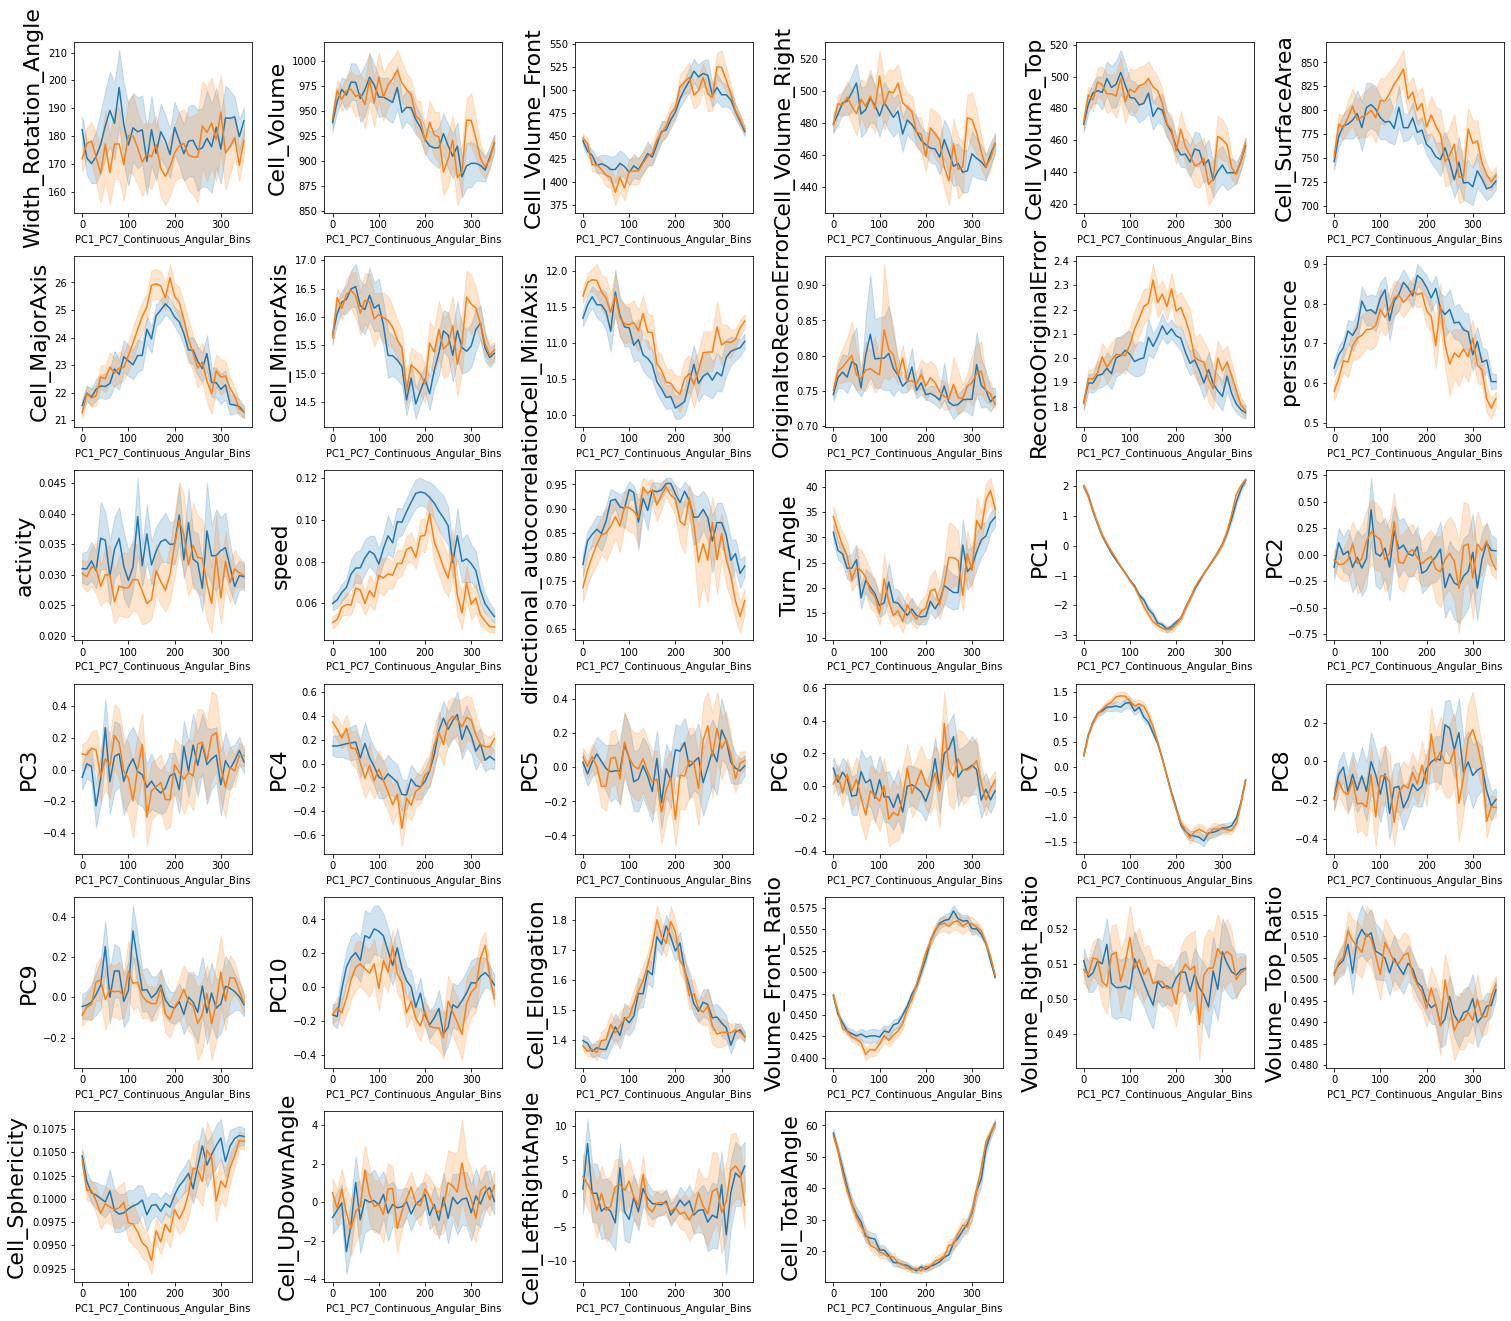

In [5]:


################# LOOK STATS AROUND 1D CYCLE ######################
removeex = []
removeex.extend([x for x in allavgsframe.columns if 'Euler' in x])
removeex.extend([x for x in allavgsframe.columns if 'avg' in x])
removeex.extend([x for x in allavgsframe.columns if 'PC1_PC2' in x])
removeex.extend([x for x in allavgsframe.columns if 'intensity' in x])
removeex.extend([x for x in allavgsframe.columns if 'Velocity' in x])
removeex.extend([x for x in allavgsframe.columns if 'Coord' in x])
removeex.extend([x for x in allavgsframe.columns if 'Centroid' in x])
removeex.extend([x for x in allavgsframe.columns if 'Trajectory' in x])
removeex.extend([x for x in allavgsframe.columns if 'Vec' in x])
removeex.extend([x for x in allavgsframe.columns if 'bins' in x])
removeex.extend(['cell','CellID','x','y','z','structure','frame','Treatment','Experiment',
                'Experiment_Number','Date','bsiter'])
newframe = allavgsframe.drop(columns =removeex)


CoRo = math.ceil(math.sqrt(len(newframe.columns)))
row = 0
fig, axes = plt.subplots(CoRo, CoRo, figsize=(3.5*CoRo,3*CoRo))#, sharex=True)

for i, ax in enumerate(axes.flatten()):
    if i<len(newframe.columns):
        if newframe.iloc[:,i].name == f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Bins':
            ax.remove()
            continue
        sns.lineplot(data = TotalFrame, x=f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Bins', 
                     y = newframe.iloc[:,i].name, hue = 'Treatment', ax = ax)
        ax.set_ylabel(newframe.iloc[:,i].name)#, fontsize = 1.75*CoRo)
        ax.legend_ = None
        ax.set_ylabel(ax.get_ylabel(), fontsize = 22)
    else:
        ax.remove()


plt.tight_layout()
plt.savefig(savedir + f'PC{whichpcs[0]}_PC{whichpcs[1]} Shape Metrics 1D Continuous PCs with bootstrapping.png', bbox_inches='tight')

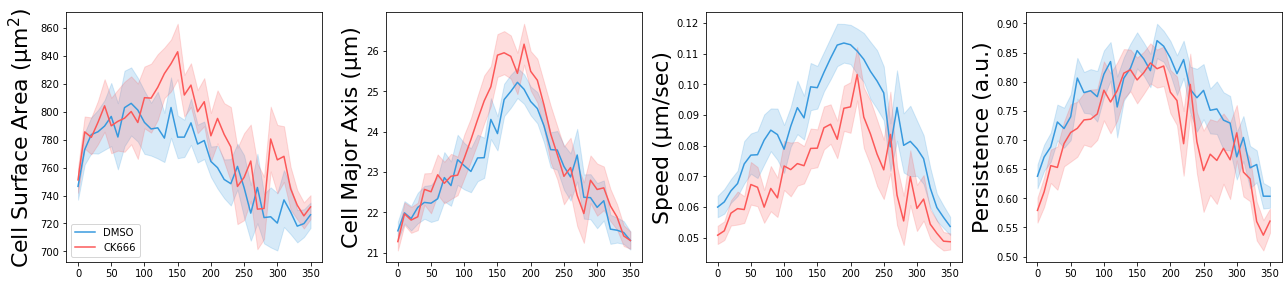

In [9]:


################# LOOK STATS AROUND 1D CYCLE ######################
colorlist = ['#3799de','#fc5858']
metrics = ['Cell_SurfaceArea','Cell_MajorAxis','speed','persistence']
metlabels = ['Cell Surface Area (µm$^2$)', 'Cell Major Axis (µm)',
             'Speed (µm/sec)','Persistence (a.u.)']
newframe = allavgsframe[metrics]


CoRo = math.ceil(math.sqrt(len(newframe.columns)))
row = 0
fig, axes = plt.subplots(1, len(metrics), figsize=(4.5*len(metrics),1*len(metrics)))#, sharex=True)

for i, ax in enumerate(axes.flatten()):
    if i<len(newframe.columns):
        if newframe.iloc[:,i].name == f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Bins':
            ax.remove()
            continue
        sns.lineplot(data = TotalFrame, x=f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Bins', 
                     y = newframe.iloc[:,i].name, palette = colorlist, hue = 'Treatment', ax = ax)
        ax.set_ylabel(metlabels[i])#, fontsize = 1.75*CoRo)
        ax.set_ylabel(ax.get_ylabel(), fontsize = 22)
        ax.set_xlabel('')
        if i!=0:
            ax.legend_ = None
        else:
            ax.legend(loc='lower left')
    else:
        ax.remove()


plt.tight_layout()
plt.savefig(savedir + f'PC{whichpcs[0]}_PC{whichpcs[1]} specific Shape Metrics 1D Continuous PCs with bootstrapping.png',
            bbox_inches='tight')